In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
train = pd.read_csv('./data/train.csv', parse_dates=[0], index_col=0)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 11 columns):
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 984.9+ KB


In [4]:
train.groupby('Trap').WnvPresent.sum().sort_values(ascending=False).head()

Trap
T900    66
T115    41
T002    18
T138    16
T003    14
Name: WnvPresent, dtype: int64

In [5]:
train.groupby('Species').WnvPresent.value_counts()

Species                 WnvPresent
CULEX ERRATICUS         0                1
CULEX PIPIENS           0             2459
                        1              240
CULEX PIPIENS/RESTUANS  0             4490
                        1              262
CULEX RESTUANS          0             2691
                        1               49
CULEX SALINARIUS        0               86
CULEX TARSALIS          0                6
CULEX TERRITANS         0              222
Name: WnvPresent, dtype: int64

In [6]:
spray = pd.read_csv('./data/spray.csv')

In [7]:
spray.Date = spray.Date.map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [8]:
spray['year'] = spray.Date.map(lambda x: x.year)

In [9]:
spray.groupby('year').count()

,Date,Time,Latitude,Longitude
year,,,,
2011,2209,1625,2209,2209
2013,12626,12626,12626,12626


In [10]:
def combine_rows(df):
    place_table = df[[
        'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'
    ]].drop_duplicates().set_index(['Address'])

    totals = df.groupby([df.index, 'Trap', 'Address', 'Species']).NumMosquitos.sum()
    has_nile = df.groupby([df.index, 'Trap', 'Address', 'Species']).WnvPresent.sum().map(lambda x: int(x > 0))
    return pd.concat([totals, has_nile], axis=1).reset_index().merge(place_table.drop('Trap', axis=1), on='Address')

In [11]:
#confused how i want to handle the df
def deal_w_stations(df2, weather):
    station1Lat = 41.995
    station1Lon = -87.933
    station2Lat = 41.786
    station2Lon = -87.752

    dist1 = abs((df2.Latitude - station1Lat)*1j + (df2.Longitude - station1Lon))
    dist2 = abs((df2.Latitude - station2Lat)*1j + (df2.Longitude - station2Lon))
    compare = dist1 < dist2
    weather_fields = weather.select_dtypes([float,int]).columns[1:]

    for field in weather_fields:
        df2[field] = df2[field + '_x']*compare + df2[field + '_y']*(1-compare)

    redundant_cols = [name for name in df2.columns if '_' in name]

    return df2.drop(redundant_cols, axis=1)

In [12]:
weather = pd.read_csv('./data/ps_weather_processed.csv', parse_dates=[0], index_col=0)\
                .assign(HCDiff = lambda df: df.Heat - df.Cool)\
                .apply(lambda col: col.replace('-',None).ffill().astype(int) if col.name in ['Sunrise', 'Sunset'] else col)\
                .drop(['Heat', 'Cool','isRain'], axis=1)


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 18 columns):
Station        2944 non-null int64
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null int64
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null int64
Sunrise        2944 non-null int64
Sunset         2944 non-null int64
CodeSum        2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null float64
SeaLevel       2944 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null float64
HCDiff         2944 non-null int64
dtypes: float64(5), int64(10), object(3)
memory usage: 517.0+ KB


In [14]:
shift_dict_default = {

}

In [15]:
#used in conjunction with apply
def weatherShiftLogic(col, shift_dict=shift_dict_default):
    if col.name in shift_dict:
        return col.shift(shift_dict[col.name])
    else:
        return col.shift(14)

In [16]:
def merge_weather(df):
    weather = pd.read_csv('./data/ps_weather_processed.csv', parse_dates=[0], index_col=0)\
                .assign(HCDiff = lambda df: df.Heat - df.Cool)\
                .apply(lambda col: col.replace('-',None).ffill().astype(int) if col.name in ['Sunrise', 'Sunset'] else col)\
                .drop(['Heat', 'Cool','isRain'], axis=1)

    a = weather.query('Station==1').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    b = weather.query('Station==2').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    df = df.set_index('Date').join([a, b]).dropna()
    return deal_w_stations(df, weather)

In [17]:
def adjust_columns(df2):
    relevant_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
    for species in relevant_species:
        df2[species] = df2.Species.map(lambda x: int(x==species))
    #df2 = df2.assign(month = df2.index.month)
    df2 = df2.select_dtypes([int, float]).drop(['Block', 'AddressAccuracy'], axis=1)
    return df2

In [18]:
def naivestrap(x, y):
    positive_index = y.reset_index().query('WnvPresent==1').index
    indices = np.random.choice(positive_index, size=len(y)-y.sum())
    return x.copy().iloc[indices,:], y.copy().iloc[indices]

In [19]:
df2 = combine_rows(train)

In [20]:
df2 = merge_weather(df2)

In [21]:
df2 = adjust_columns(df2)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve

In [23]:
x = df2.drop(['WnvPresent','NumMosquitos'], axis=1)
y = df2.WnvPresent

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

In [24]:
xtrainint, ytrainint = naivestrap(xtrain, ytrain)
xtrain = pd.concat([xtrain, xtrainint])
ytrain = pd.concat([ytrain, ytrainint])

In [25]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=2, max_depth=None, max_features='auto', class_weight=None)
rf.fit(xtrain, ytrain)
model = rf
rf.score(xtest, ytest)

0.9233189146677153

In [26]:
probas = [row[1] for row in model.predict_proba(xtest)]

In [27]:
sum(probas)

197.68000000000015

In [28]:
roc_auc_score(ytest, probas)

0.7853258877294167

In [29]:
roc_auc_score(ytrain, [proba[1] for proba in rf.predict_proba(xtrain)])

0.9999999999999999

In [30]:
list(zip(xtrain.columns, model.feature_importances_))

[('Latitude', 0.20913396941489903),
 ('Longitude', 0.2259368486276278),
 ('Tmax', 0.021840685788002377),
 ('Tmin', 0.019172582567877593),
 ('Tavg', 0.030838884109144215),
 ('DewPoint', 0.02953255432925679),
 ('WetBulb', 0.02931184422205435),
 ('Sunrise', 0.10768249153024968),
 ('Sunset', 0.07625154229096681),
 ('PrecipTotal', 0.020820259864349835),
 ('StnPressure', 0.020288280619249133),
 ('SeaLevel', 0.025138895550507866),
 ('ResultSpeed', 0.031498527465059316),
 ('ResultDir', 0.02198124683696436),
 ('AvgSpeed', 0.028557784529659756),
 ('HCDiff', 0.02761303277359941),
 ('CULEX PIPIENS', 0.020508949884698802),
 ('CULEX PIPIENS/RESTUANS', 0.02383978569928648),
 ('CULEX RESTUANS', 0.03005183389654661)]

In [31]:
np.mean(probas)

0.07773495871018482

In [32]:
model.predict_proba(xtest)

array([[0.99, 0.01],
       [1.  , 0.  ],
       [0.91, 0.09],
       ...,
       [0.8 , 0.2 ],
       [0.96, 0.04],
       [1.  , 0.  ]])

In [33]:
b = pd.DataFrame(probas, index=ytest.index)

In [34]:
inspect = pd.concat([xtest, b, ytest], axis=1).rename({0:'proba', 'WnvPresent':'actual'}, axis=1)

In [35]:
inspect.shape

(2543, 21)

False negatives at threshold (0.5 at time of shift enter)

In [36]:
inspect.query('actual==1').assign(new = lambda df: abs(df.actual - df.proba)).query('new>0.5').shape[0]/ytest.sum()

0.7867647058823529

In [37]:
inspect.actual.mean()

0.053480141565080616

In [38]:
inspect.loc[abs(inspect.proba - inspect.actual)<.5].actual.mean()

0.012366737739872069

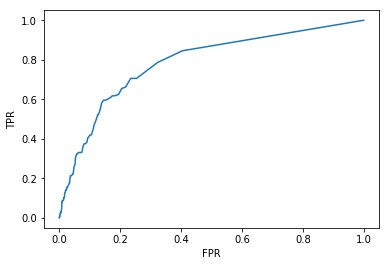

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
points = roc_curve(ytest, probas)
plt.plot(points[0], points[1])
plt.xlabel('FPR')
plt.ylabel('TPR');

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

In [41]:
extra = ExtraTreesClassifier(n_estimators=1000, max_depth=None, bootstrap=False, min_samples_leaf=100, min_samples_split=200, class_weight=None, warm_start=True)
extra.fit(xtrain['2007'], ytrain['2007'])
extra.score(xtest, ytest)

0.7723161620133701

In [42]:
extra.set_params(n_estimators=2000)
extra.fit(xtrain['2009'], ytrain['2009'])
extra.set_params(n_estimators=3000)
extra.fit(xtrain['2011'], ytrain['2011'])
extra.set_params(n_estimators=4000)
extra.fit(xtrain['2013'], ytrain['2013'])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=200,
           min_weight_fraction_leaf=0.0, n_estimators=4000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [43]:
roc_auc_score(ytest, [proba[1] for proba in extra.predict_proba(xtest)])

0.7909834062415994

In [44]:
roc_auc_score(ytrain, [proba[1] for proba in extra.predict_proba(xtrain)])

0.7822653051340607

In [45]:
model=extra

In [46]:
list(zip(xtrain.columns, model.feature_importances_))

[('Latitude', 0.05111185443222632),
 ('Longitude', 0.08383717123167277),
 ('Tmax', 0.034512082679295404),
 ('Tmin', 0.03886971539364472),
 ('Tavg', 0.04036210625373013),
 ('DewPoint', 0.04680363781413293),
 ('WetBulb', 0.052876315712041655),
 ('Sunrise', 0.11400463509106869),
 ('Sunset', 0.081981256755837),
 ('PrecipTotal', 0.035571192327328985),
 ('StnPressure', 0.02781695289674334),
 ('SeaLevel', 0.03339970380985758),
 ('ResultSpeed', 0.03990541006199068),
 ('ResultDir', 0.05382930156894767),
 ('AvgSpeed', 0.04148626768781266),
 ('HCDiff', 0.0408979378777448),
 ('CULEX PIPIENS', 0.04200613669013284),
 ('CULEX PIPIENS/RESTUANS', 0.05763383537583749),
 ('CULEX RESTUANS', 0.08184448633995448)]

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
grad = GradientBoostingClassifier(loss='exponential', n_estimators=1000, max_depth=2, subsample=0.3, warm_start=True)

In [49]:
grad.fit(xtrain['2007'], ytrain['2007'])
print(grad.score(xtrain, ytrain))
print(grad.score(xtest, ytest))

0.6969591960495538
0.8918600078647267


In [50]:
roc_auc_score(ytrain, [proba[1] for proba in grad.predict_proba(xtrain)])

0.7864982124386484

In [51]:
roc_auc_score(ytest, [proba[1] for proba in grad.predict_proba(xtest)])

0.7385261125638456

In [52]:
model=grad

# Processing test data

In [53]:
test = pd.read_csv('./data/test.csv')
test = adjust_columns(merge_weather(test)).drop('Id', axis=1)
submission = pd.DataFrame([predictions[1] for predictions in model.predict_proba(test)], columns=['WnvPresent'])
submission = submission.reset_index().rename({'index':'Id'}, axis=1)
submission.loc[:,'Id'] = submission.Id + 1
submission = submission.set_index('Id')
submission.to_csv('submission.csv')